## Analyze Sparsity

In [1]:
import torch
import os

def load_model_weights(model_path):
    """Load model weights from a .pth file."""
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
    model_state = checkpoint["student_model_state_dict"]
    return {k: v.cpu().numpy() for k, v in model_state.items() if "weight" in k}

def compute_sparsity(weights_dict):
    """Compute the sparsity of model weights (per layer)."""
    sparsity = {}
    for layer_name, weights in weights_dict.items():
        num_elements = weights.size
        num_zeros = (abs(weights) < 1e-4).sum()
        sparsity[layer_name] = num_zeros / num_elements    
    return sparsity

def compute_layerwise_sparsity(directory):
    """Compute and print layer-wise sparsity for each model in a folder."""
    for root, _, files in os.walk(directory):
        for file in files:
            if not file.endswith(".pth"):
                continue

            model_path = os.path.join(root, file)
            weights_dict = load_model_weights(model_path)
            sparsity = compute_sparsity(weights_dict)

            print(f"\nModel: {file}")
            for layer_name, sparsity_value in sparsity.items():
                print(f"  {layer_name}: {sparsity_value * 100:.2f}% sparsity")

In [2]:
compute_layerwise_sparsity("../experiment_output/Experiment4/experiments_exp4_l1_init0.2_42")


Model: nonoverlappingCNN_sigmoid__fcnn_sigmoid.pth
  layers.0.weight: 100.00% sparsity
  layers.1.weight: 100.00% sparsity
  layers.2.weight: 0.00% sparsity

Model: nonoverlappingCNN_sigmoid__fcnn_relu.pth
  layers.0.weight: 47.20% sparsity
  layers.1.weight: 97.52% sparsity
  layers.2.weight: 95.31% sparsity

Model: nonoverlappingCNN_relu__fcnn_tanh.pth
  layers.0.weight: 67.25% sparsity
  layers.1.weight: 98.46% sparsity
  layers.2.weight: 95.31% sparsity

Model: nonoverlappingCNN_tanh__fcnn_sigmoid.pth
  layers.0.weight: 100.00% sparsity
  layers.1.weight: 100.00% sparsity
  layers.2.weight: 0.00% sparsity

Model: nonoverlappingCNN_tanh__fcnn_relu.pth
  layers.0.weight: 63.35% sparsity
  layers.1.weight: 95.71% sparsity
  layers.2.weight: 88.28% sparsity

Model: nonoverlappingCNN_tanh__fcnn_tanh.pth
  layers.0.weight: 97.14% sparsity
  layers.1.weight: 99.96% sparsity
  layers.2.weight: 98.44% sparsity

Model: nonoverlappingCNN_relu__fcnn_relu.pth
  layers.0.weight: 98.24% sparsity

## Look at heatmaps

In [92]:
import os
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec

def load_model_weights(model_path):
    """Load model weights from a .pth file."""
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
    model_state = checkpoint["student_model_state_dict"]
    return {k: v.cpu().numpy() for k, v in model_state.items() if "weight" in k}

def create_heatmaps(weights_dict):
    num_layers = len(weights_dict)

    height_ratios = []
    for i in range(num_layers):
        if i == 1:
            height_ratios.append(2.0)  # Layer 2
        elif i == 2:
            height_ratios.append(1.5)  # Layer 3
        else:
            height_ratios.append(1.0)  # Others

    total_height = sum(height_ratios)
    fig = plt.figure(figsize=(10, 1.5 * total_height))
    gs = gridspec.GridSpec(num_layers, 1, height_ratios=height_ratios, hspace=0.25)
    axes = [fig.add_subplot(gs[i]) for i in range(num_layers)]
    
    im = None

    for i, (layer_name, weights) in enumerate(weights_dict.items()):
        ax = axes[i]
        rows, cols = weights.shape

        # Rotate if vertical
        if rows > cols:
            weights = weights.T
            rows, cols = weights.shape

        # Heatmap
        im = ax.imshow(weights, cmap="RdBu", aspect="equal", vmin=-2, vmax=2)

        clean_name = f"Layer {int(layer_name.split('.')[1]) + 1}"
        ax.set_title(f"{clean_name} (dimension {rows}×{cols})", fontsize=11, pad=4)
        ax.invert_yaxis()
        if rows == 1:
            ax.set_yticks([])

    # Add slim colorbar well outside the plots
    cbar_ax = fig.add_axes([0.91, 0.27, 0.015, 0.64])  # Shifted right to avoid overlap
    fig.colorbar(im, cax=cbar_ax)

    plt.subplots_adjust(left=0.06, right=0.88, top=0.94, bottom=0.06)

    # Slightly shift Layer 3 down
    for i, ax in enumerate(axes):
        if i == 2:
            pos = ax.get_position()
            ax.set_position([pos.x0, pos.y0 + 0.09, pos.width, pos.height])

    plt.show()


In [93]:
def create_all_heatmaps(directory):
    model_files = [f for f in os.listdir(directory) if f.endswith(".pth")]
    for model_file in model_files:
        model_path = os.path.join(directory, model_file)
        print(f"\nLoading weights from {model_file}...")
        
        weights_dict = load_model_weights(model_path)
        create_heatmaps(weights_dict)
        sparsity = compute_sparsity(weights_dict)
        for layer_name, sparsity_value in sparsity.items():
            print(f"Sparsity of {layer_name}: {sparsity_value * 100:.2f}%")


Loading weights from nonoverlappingCNN_sigmoid__fcnn_sigmoid.pth...


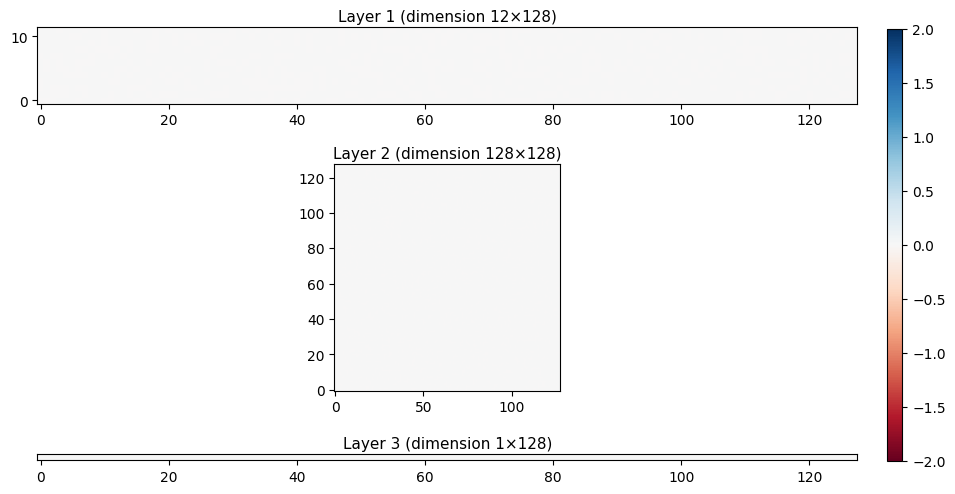

Sparsity of layers.0.weight: 100.00%
Sparsity of layers.1.weight: 100.00%
Sparsity of layers.2.weight: 0.00%

Loading weights from nonoverlappingCNN_sigmoid__fcnn_relu.pth...


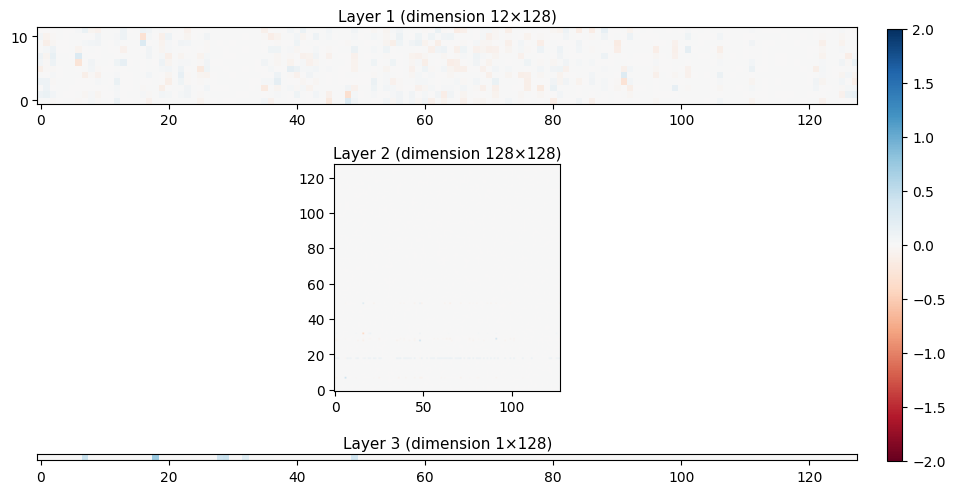

Sparsity of layers.0.weight: 47.20%
Sparsity of layers.1.weight: 97.52%
Sparsity of layers.2.weight: 95.31%

Loading weights from nonoverlappingCNN_relu__fcnn_tanh.pth...


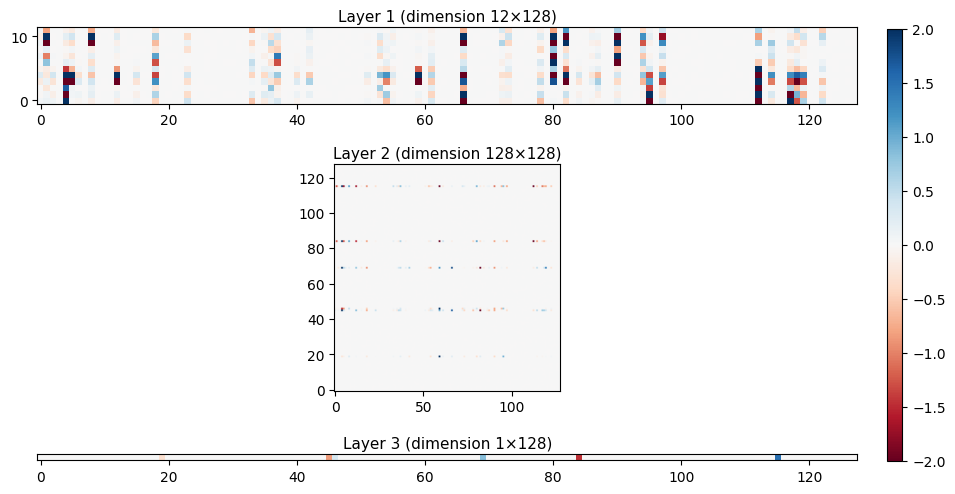

Sparsity of layers.0.weight: 67.25%
Sparsity of layers.1.weight: 98.46%
Sparsity of layers.2.weight: 95.31%

Loading weights from nonoverlappingCNN_tanh__fcnn_sigmoid.pth...


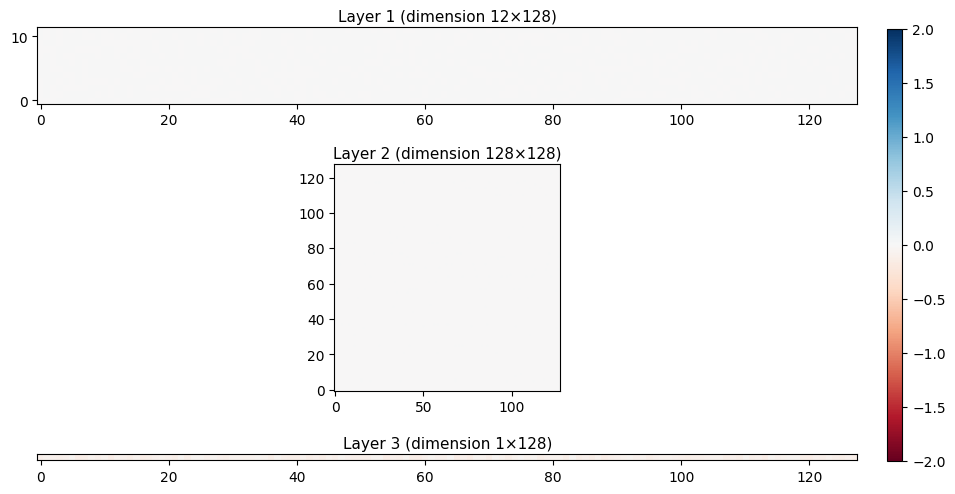

Sparsity of layers.0.weight: 100.00%
Sparsity of layers.1.weight: 100.00%
Sparsity of layers.2.weight: 0.00%

Loading weights from nonoverlappingCNN_tanh__fcnn_relu.pth...


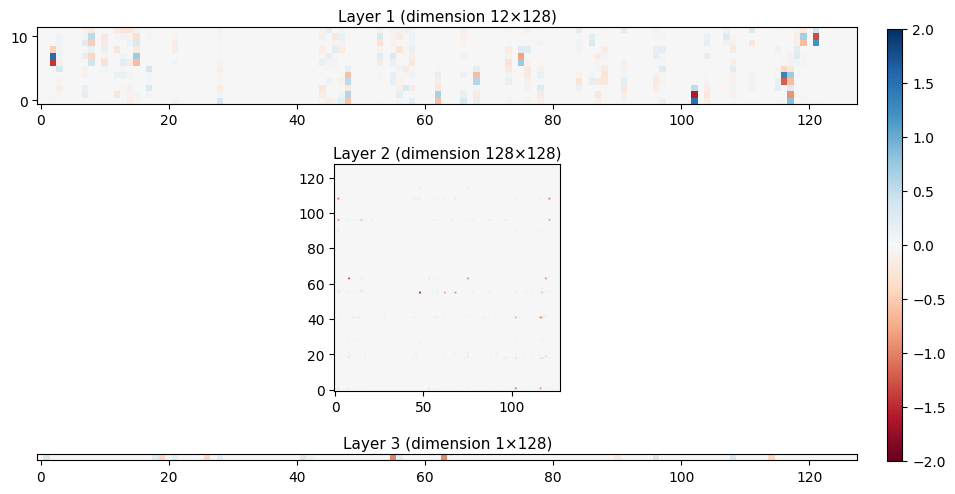

Sparsity of layers.0.weight: 63.35%
Sparsity of layers.1.weight: 95.71%
Sparsity of layers.2.weight: 88.28%

Loading weights from nonoverlappingCNN_tanh__fcnn_tanh.pth...


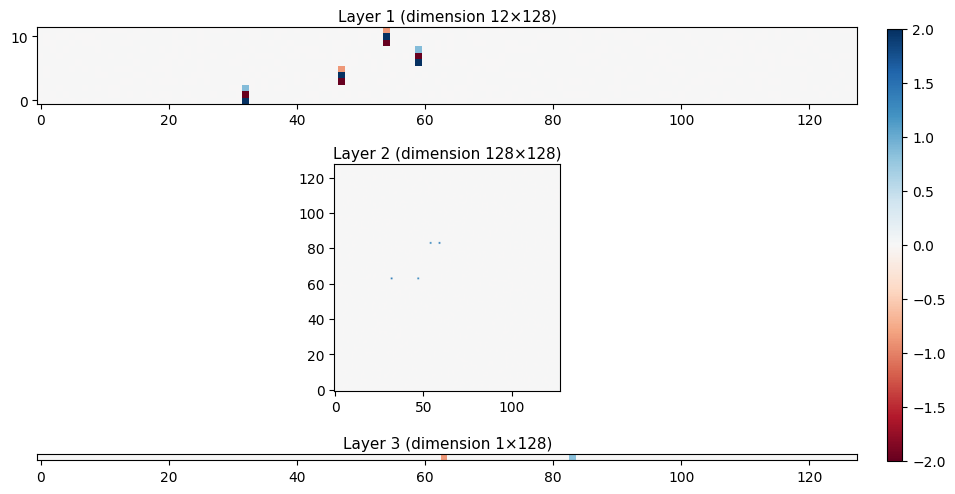

Sparsity of layers.0.weight: 97.14%
Sparsity of layers.1.weight: 99.96%
Sparsity of layers.2.weight: 98.44%

Loading weights from nonoverlappingCNN_relu__fcnn_relu.pth...


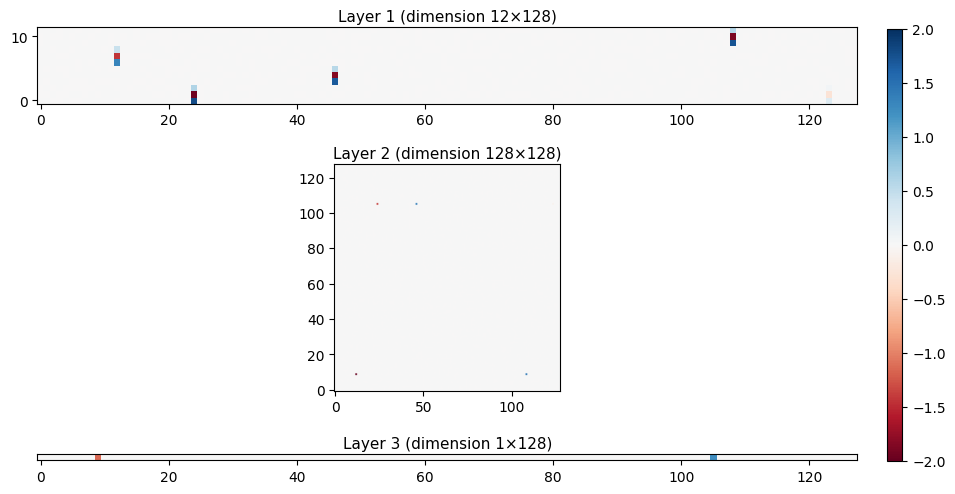

Sparsity of layers.0.weight: 98.24%
Sparsity of layers.1.weight: 99.96%
Sparsity of layers.2.weight: 98.44%

Loading weights from nonoverlappingCNN_relu__fcnn_sigmoid.pth...


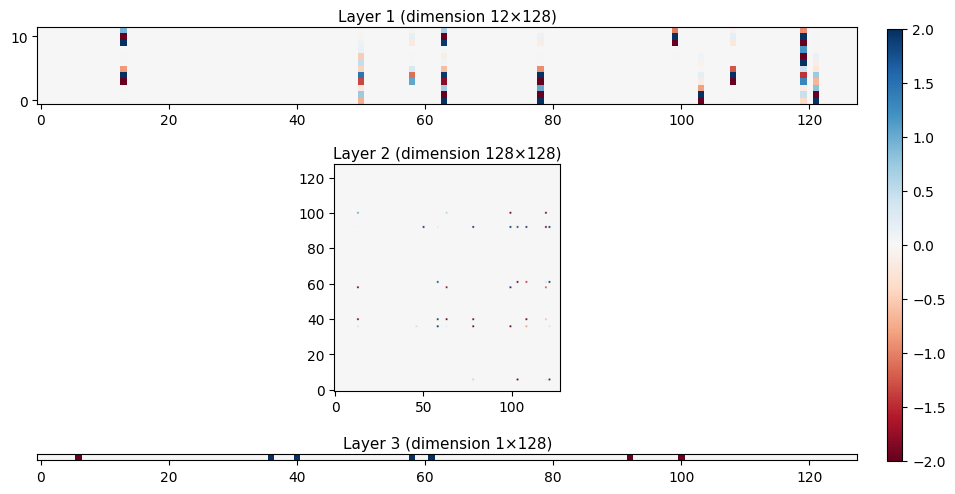

Sparsity of layers.0.weight: 91.67%
Sparsity of layers.1.weight: 94.55%
Sparsity of layers.2.weight: 94.53%

Loading weights from nonoverlappingCNN_sigmoid__fcnn_tanh.pth...


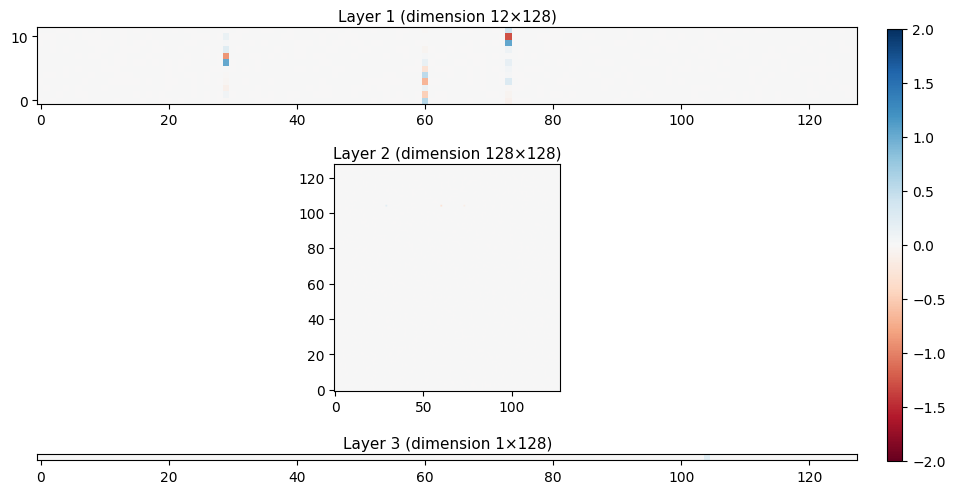

Sparsity of layers.0.weight: 97.66%
Sparsity of layers.1.weight: 99.98%
Sparsity of layers.2.weight: 99.22%


In [94]:
create_all_heatmaps("../experiment_output/Experiment4/experiments_exp4_l1_init0.2_42")